In [1]:
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from functools import partial

from collections import defaultdict

import isolearn.keras as iso

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)

digit_train = np.argmax(y_train, axis=1)
digit_test = np.argmax(y_test, axis=1)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


In [10]:
predictor = Sequential()

predictor.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
predictor.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
predictor.add(MaxPooling2D(pool_size=(2, 2)))
predictor.add(Dropout(0.25))
predictor.add(Flatten())
predictor.add(Dense(128, activation='relu', name='dense_1'))
predictor.add(Dropout(0.5))
predictor.add(Dense(num_classes, activation='softmax', name='dense_2'))

predictor.load_weights('saved_models/mnist_binarized_cnn_10_digits.h5')
predictor.trainable = False

predictor.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

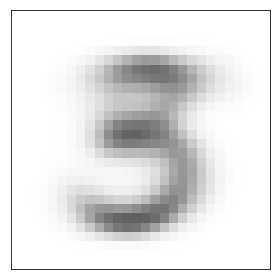

In [11]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


perc_50 = 1.0
perc_80 = 1.0
perc_90 = 1.0


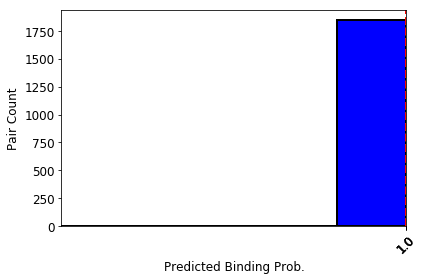

In [23]:
#Plot distribution of positive binding prediction and calculate percentiles

y_pred_test = predictor.predict(x=[x_test], batch_size=32)[np.arange(x_test.shape[0]), digit_test.tolist()]

perc_50 = round(np.quantile(y_pred_test, q=0.5), 6)
perc_80 = round(np.quantile(y_pred_test, q=0.8), 6)
perc_90 = round(np.quantile(y_pred_test, q=0.9), 6)

print("perc_50 = " + str(perc_50))
print("perc_80 = " + str(perc_80))
print("perc_90 = " + str(perc_90))

f = plt.figure(figsize=(6, 4))

plt.hist(y_pred_test, bins=100, edgecolor='black', color='blue', linewidth=2)

plt.axvline(x=perc_50, color='green', linewidth=2, linestyle="--")
plt.axvline(x=perc_80, color='orange', linewidth=2, linestyle="--")
plt.axvline(x=perc_90, color='red', linewidth=2, linestyle="--")

plt.xlabel("Predicted Binding Prob.", fontsize=12)
plt.ylabel("Pair Count", fontsize=12)

t = np.array([perc_50, perc_80, perc_90])

plt.xticks(t, t, fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.xlim(0.95, 1)
plt.ylim(0)

plt.tight_layout()

plt.show()


In [39]:
import sis

#Run SIS on test set

fixed_threshold = 0.95
dynamic_threshold_scale = 0.8

n_seqs_to_test = x_test.shape[0]

importance_scores_test = []

predictor_calls_test = []

for data_ix in range(200) :#range(n_seqs_to_test) :
    
    if data_ix % 100 == 0 :
        print("Processing example " + str(data_ix) + "...")
    
    threshold = fixed_threshold if y_pred_test[data_ix] >= fixed_threshold * (1. / dynamic_threshold_scale) else dynamic_threshold_scale * y_pred_test[data_ix]

    x_curr = x_test[data_ix, ...]
    d_curr = digit_test[data_ix]

    bg = x_mean[..., None]
    
    predictor_counter = { 'acc' : 0 }
    
    def _temp_pred_func(batch, d=d_curr, predictor_counter=predictor_counter) :
        
        temp_data = np.concatenate([arr[None, ...] for arr in batch], axis=0)
        
        predictor_counter['acc'] += temp_data.shape[0]
        
        temp_out = predictor.predict(x=[temp_data], batch_size=64)[:, d]
        
        return temp_out

    F_PRED = lambda batch: _temp_pred_func(batch)

    x_fully_masked = np.copy(bg)

    initial_mask = sis.make_empty_boolean_mask_broadcast_over_axis(x_curr.shape, 2)

    collection = sis.sis_collection(F_PRED, threshold, x_curr, x_fully_masked, initial_mask=initial_mask)
    
    importance_scores_test_curr = np.zeros(x_curr.shape)[None, ...]
    if collection[0].sis.shape[0] > 0 :
        
        imp_index_x = collection[0].sis[:, 0].tolist()
        imp_index_y = collection[0].sis[:, 1].tolist()

        importance_scores_test_curr[0, imp_index_x, imp_index_y, :] = 1.

    importance_scores_test.append(importance_scores_test_curr)
    
    predictor_calls_test.append(predictor_counter['acc'])

importance_scores_test = np.concatenate(importance_scores_test, axis=0)

predictor_calls_test = np.array(predictor_calls_test)


Processing example 0...
Processing example 100...


In [40]:
#Print predictor call statistics

print("Total number of predictor calls   = " + str(np.sum(predictor_calls_test)))
print("Average number of predictor calls = " + str(np.mean(predictor_calls_test)))


Total number of predictor calls   = 235939067
Average number of predictor calls = 1179695.335


Test image 0:


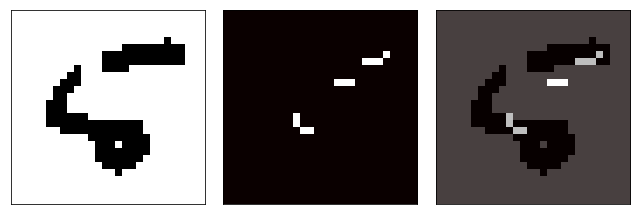

Test image 1:


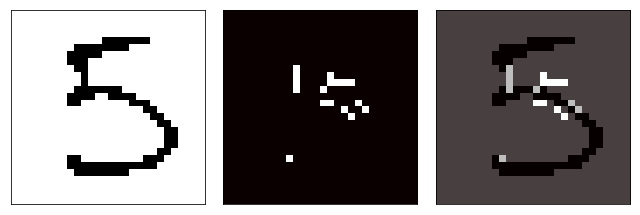

Test image 2:


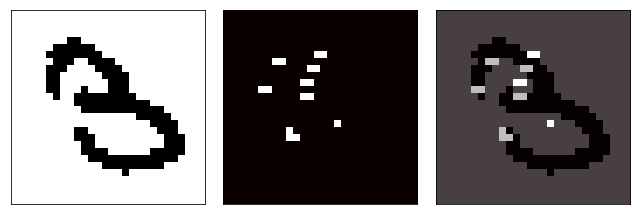

Test image 3:


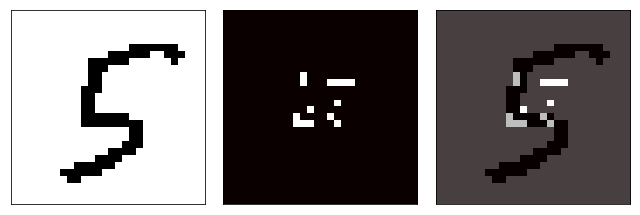

Test image 4:


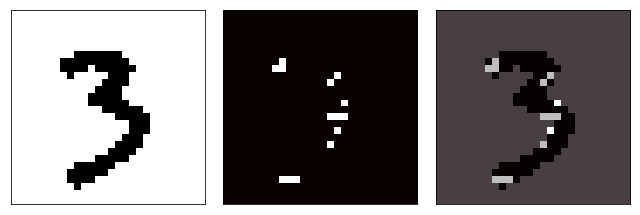

In [41]:
#Visualize a few images

for plot_i in range(0, 5) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [42]:
#Save predicted importance scores

model_name = "sufficient_input_subsets_" + dataset_name + "_thresh_095_mean"

np.save(model_name + "_importance_scores_test", importance_scores_test)
